In [26]:
from qiskit_aer.utils import approximate_quantum_error, approximate_noise_model
import numpy as np
from qiskit_aer.noise import amplitude_damping_error, reset_error, pauli_error
from qiskit.quantum_info import Kraus
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

# 7. Matrix Product state simulation method

#### aer은 statevector, stabilizer, extended_stabilizer, matrix_product_state 등등을 포함하는 많은 시뮬레이션 방법을 지원한다

In [3]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

#### aer_simulator_matrix_product_state는 slightly entangled 상태에 한정해서 계산 속도가 매우 빠른 시뮬레이터

#### 어떻게 빠르게 만들 수 있는지에 대해서 자세히 알아볼 것임

관련 논문 : 

https://arxiv.org/abs/quant-ph/0301063 : Efficient classical simulation of slightly entangled quantum computations (2008)

'slightly entangled state'에 한해 이 방법이 효과적인 계산량 감소를 얻을 수 있다는 것을 나타냄.

https://arxiv.org/abs/1008.3477 : The density-matrix renormalization group in the age of matrix product states

세부적인 설명들(약 120쪽)

2차원 힐베르트 공간에서 n개의 스핀이 중첩된 상태의 일반적인 표현은 계수의 개수가 지수함수적으로 증가함.

### $|\psi\rangle = \Sigma^1_{i_1=0}\Sigma^1_{i_2=0} ... \Sigma^1_{i_n=0}c_{i_1i_2...i_n}|i_1\rangle\ \otimes...\otimes|i_n\rangle$ $\cdot$ $\cdot$ $\cdot$ ($\star$)


ex) 2차원 힐베르트 공간의 2-cubit system $|\psi\rangle=c_{00}|00\rangle+c_{01}|01\rangle+c_{10}|10\rangle+c_{11}|11\rangle$



but MPS(Matrix product state) 표현을 사용하면, $|\psi\rangle$를 텐서와 벡터로 분해할 수 있음. 

#### Schmidt Decomposition : tensor product로 만들어진 계 내부 임의의 pure state는 subset의 basis들의 tensor product로 나타낼 수 있다

### $|\psi\rangle => \Gamma^{[1]}\lambda^{[1]}\Gamma^{[2]}\lambda^{[2]}...\Gamma^{[l]}...\lambda^{[n-1]}\Gamma^{[n]}$의 형태

$\Gamma^{[l]}$ : l번째 큐빗을 나타내는 텐서

$\lambda^{[l]}$ : Normalization 벡터

#### 이렇게 나타내는 게 왜 좋나?? ㅡ> 계산복잡도가 exponential에서 polynomial로 바뀜

#### Lemma 1. :

Updating the description ($\star$) of state $|\psi \rangle$ after a unitary operation U acts on qubit $l$ does only involve transforming $\Gamma^{[l]}$. The incurred computational cost is of $\varnothing(\chi^2$) basic operations.


ㅡ> qubit $l$에 가해지는 유니터리는 $\Gamma^{[l]}$만 변화시킨다.

#### Lemma 2. : 

Updating the description (4) of state $|\psi \rangle$ after a unitary operation V acts on qubits $l$ and $l + 1$
does only involve transforming $\Gamma^{[l]}$, $\lambda^{[l]}$ and $\Gamma^{[l+1]}$. This
can be achieved with Ø($\chi^3$) basic operations.

ㅡ> 큐빗 $l$과 $l+1$에 작용하는 two qubit gate는 $\Gamma^{[l]}$, $\lambda^{[l]}$, $\Gamma^{[l+1]}$ 만 변화시킨다.

#### ㅡㅡ> 계산 복잡도가 polynomial 형태로 증가한다

우리가 이 방법을 simulator에서 사용할 수 있는 이유 :

#### Theorem 1. : 

If through a pure-state quantum computation $\chi_n$ is upper bounded by poly(n), then the computation can be classically simulated with poly(n) memory space and computational time.

복잡도가 poly(n) 형태로 증가하면, poly(n)만큼의 memory space와 computational time으로 시뮬레이션이 가능하다.

#### Theorem 2. :
    
If $\chi_n$ grows subexponentially in n, then the quantum computation can be classically simulated with subexp(n) memory space and computational
time.

subexponentially하게 증가하면, 자원도 그만큼 필요하다

ㅡ> Classical computer에 비해 exponential한 계산시간 감소가 되지 않을 조건을 알려줌

장점 : 빠름. (회로 게이트 상태에 따라 highly-entangled 되어있거나 noise가 매우 높으면 장점이 사라질 수도 있음)

단점 : 실행 중에 상태벡터를 생성하는 과정이 들어가 있으면, 장점이 사라짐. 상태벡터로 변환하는 과정은 지수함수적인 계산량을 요구하기 때문.


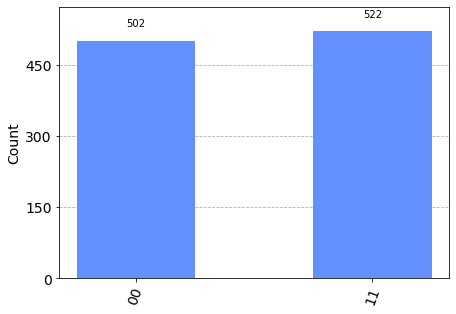

In [51]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Construct quantum circuit
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0,1], [0,1])

# Select the AerSimulator from the Aer provider
simulator = AerSimulator(method='matrix_product_state')
try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)
# Run and get counts, using the matrix_product_state method
tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
data = result.data(0)
counts = result.get_counts(0)
plot_histogram(counts)
#data

In [28]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)

# Define a snapshot that shows the current state vector
circ.save_statevector(label='my_sv')
circ.save_matrix_product_state(label='my_mps')
circ.measure([0,1], [0,1])

# Execute and get saved data
tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
data = result.data(0)

#print the result data
data

{'counts': {'0x0': 501, '0x3': 523},
 'my_sv': Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
              0.70710678+0.j],
             dims=(2, 2)),
 'my_mps': ([(array([[1.-0.j, 0.-0.j]]), array([[0.-0.j, 1.-0.j]])),
   (array([[1.-0.j],
           [0.-0.j]]),
    array([[0.-0.j],
           [1.-0.j]]))],
  [array([0.70710678, 0.70710678])])}

In [59]:
num_qubits = 21
circ = QuantumCircuit(num_qubits, num_qubits)

# Create EPR state
circ.h(0)
for i in range (0, num_qubits-1):
    circ.cx(i, i+1)

# Measure
circ.save_statevector(label='my_sv')
#circ.save_matrix_product_state(label='my_mps')
circ.measure(range(num_qubits), range(num_qubits))

tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
print("Time taken: {} sec".format(result.time_taken))
counts = result.get_counts()
counts

Time taken: 2.3447325229644775 sec


{'111111111111111111111': 518, '000000000000000000000': 506}

In [70]:
num_qubits = 200
circ = QuantumCircuit(num_qubits, num_qubits)

# Create EPR state
circ.h(0)
for i in range (0, num_qubits-1):
    circ.cx(i, i+1)

# Measure
circ.measure(range(num_qubits), range(num_qubits))

tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
print("Time taken: {} sec".format(result.time_taken))
counts = result.get_counts()
counts

Time taken: 1.47007155418396 sec


{'11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111': 508,
 '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000': 516}